## Generation of the map guassian covariance

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import camb
from matplotlib.colors import LogNorm, SymLogNorm
from generate_full_covariance import *
from save_full_covariance import *


In [2]:
def generate_power_spectra_CAMB(Nside,  r=10**(-2), Alens=1, H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, ns=0.965, lens_potential_accuracy=1, nt=0, ntrun=0, type_power='total', typeless_bool=False):
    """
    Return [Cl^TT, Cl^EE, Cl^BB, Cl^TE]
    """
    lmax = 2*Nside
    # pars = camb.CAMBparams(max_l_tensor=lmax, parameterization='tensor_param_indeptilt')
    pars = camb.CAMBparams(max_l_tensor=lmax)
    pars.WantTensors = True

    pars.Accuracy.AccurateBB = True
    pars.Accuracy.AccuratePolarization = True
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, tau=tau, Alens=Alens)
    pars.InitPower.set_params(As=2e-9, ns=ns, r=r, parameterization='tensor_param_indeptilt', nt=nt, ntrun=ntrun)
    pars.max_eta_k_tensor = lmax + 100  # 15000  # 100

    # pars.set_cosmology(H0=H0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=lens_potential_accuracy)

    print("Calculating spectra from CAMB !")
    results = camb.get_results(pars)

    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True, lmax=lmax)    
    if typeless_bool:
        return powers
    return powers[type_power]

In [3]:
# nside = 512
nside = 64*2
camb_cls = generate_power_spectra_CAMB(nside)

Calculating spectra from CAMB !


In [4]:
nside = 64
camb_cls = camb_cls[:2*nside+1,:]

In [5]:
maps_TQU = hp.synfast(camb_cls.T,nside, new=True)

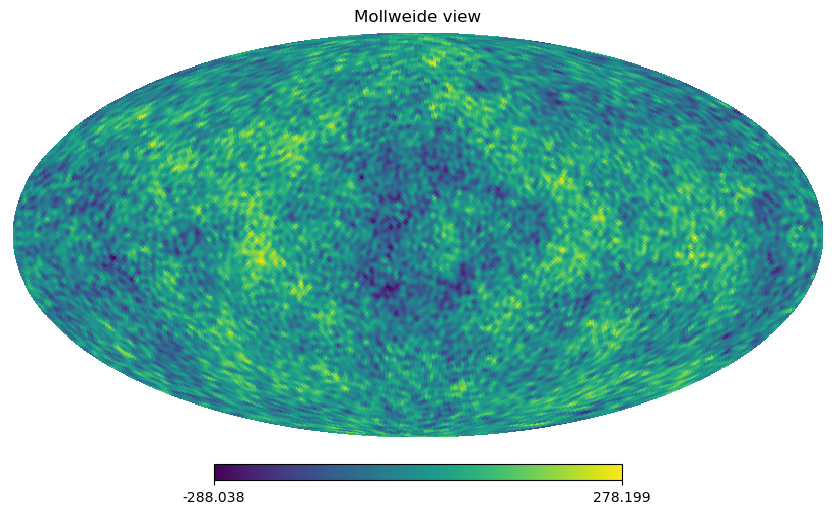

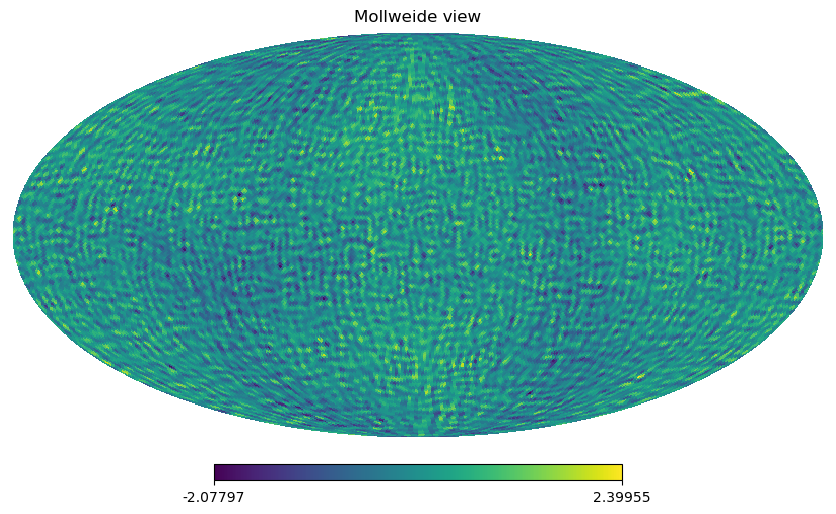

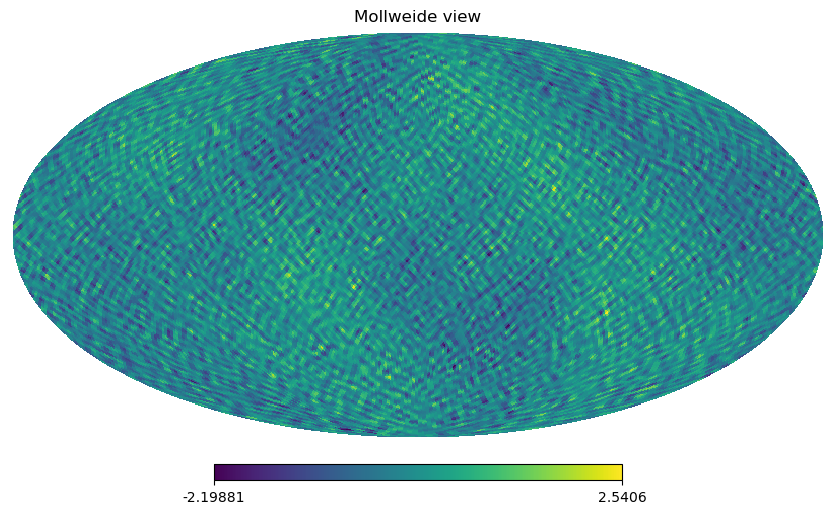

In [6]:
hp.mollview(maps_TQU[0])
hp.mollview(maps_TQU[1])
hp.mollview(maps_TQU[2])

In [7]:
def save_fits_file_from_array(array_to_save, name_column_array, directory_path='', outname=''):
    """ Save arrays with corresponding name_column_array in directory_path+outname
        Note that the first index of the array_to_save will correspond to the number of columns recorded in the fits file

        To save c_ells, the array_to_save should be a vector in 1 dimension
        name_column_array must be a list of the name of the array, even if there is only 1 array
    """
    
    print('Shape array', array_to_save.shape)
    print('Recording 3-maps in', directory_path, outname)
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH GIVEN TO SAVE FITS FILE !')
    
    dimension_array = array_to_save.shape[0]

    list_hdu = [fits.PrimaryHDU(array_to_save)]
    if len(array_to_save.shape) == 1:
        list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=name_column_array[0], array=array_to_save, format='1D')]))
    else :
        list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=name_column_array[i], array=array_to_save[i,:], format='1D') for i in range(dimension_array)]))

    hdu_list = fits.HDUList(list_hdu)
    # Header = fits.Header()


    if directory_path[-1] != '/':
        directory_path += '/'
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)

def save_map_Xpure_from_maps(maps_TQU_, directory_path='', outname=''):
    """ maps_TQU_ must have the dimension (3, 12*nside**2)
    """
    print('Shape maps TQU', maps_TQU_.shape)
    print('Recording 3-maps in', directory_path, outname)
    map_names = ['T', 'Q', 'U']
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH TO SAVE !!!')
        return
    list_hdu = [fits.PrimaryHDU(maps_TQU_)]
    list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=map_names[i], array=maps_TQU_[i,:], format='1D') for i in range(3)]))

    hdu_list = fits.HDUList(list_hdu)
    Header = fits.Header()
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)


In [8]:
save_fits_file_from_array(np.ravel(camb_cls[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128')
camb_cls_woTE = np.zeros_like(camb_cls)
camb_cls_woTE[:,:3] = camb_cls[:,:3]
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_woTE')
camb_cls_woTE[:,0] = 0
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_woTTTE')
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,1:3].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_woTTTE_v2')
camb_cls_only_BB = np.zeros_like(camb_cls)
camb_cls_only_BB[:,2] = camb_cls[:,2]
save_fits_file_from_array(np.ravel(camb_cls_only_BB[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_only_BB')
camb_cls_only_EEBB = np.zeros_like(camb_cls)
camb_cls_only_EEBB[:,1:3] = camb_cls[:,1:3]
save_fits_file_from_array(np.ravel(camb_cls_only_EEBB[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_128_only_EEBB')

Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_woTE
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_woTTTE
Shape array (256,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_woTTTE_v2
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_only_BB
Shape array (512,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_128_only_EEBB


In [12]:
maps_TQU = hp.synfast(camb_cls.T,nside, new=True)

path_output_map = '/global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/'
outname = 'Map_test_band_limited_128.fits'
save_map_Xpure_from_maps(maps_TQU, directory_path=path_output_map, outname=outname)

outname = 'Map_test_band_limited_woTE_128.fits'
maps_TQU_woTTTE = hp.synfast(camb_cls_woTE.T,nside, new=True)
save_map_Xpure_from_maps(maps_TQU_woTTTE, directory_path=path_output_map, outname=outname)

camb_cls_woTE_b = np.zeros_like(camb_cls)
camb_cls_woTE_b[:,:3] = camb_cls[:,:3]
outname = 'Map_test_band_limited_woTE_128.fits'
maps_TQU_woTE = hp.synfast(camb_cls_woTE_b.T,nside, new=True)
save_map_Xpure_from_maps(maps_TQU_woTE, directory_path=path_output_map, outname=outname)

outname = 'Map_test_band_limited_onlyEEBB_128.fits'
maps_TQU_only_EEBB = hp.synfast(camb_cls_only_EEBB.T,nside, new=True)
save_map_Xpure_from_maps(maps_TQU_only_EEBB, directory_path=path_output_map, outname=outname)

Shape maps TQU (3, 49152)
Recording 3-maps in /global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/ Map_test_band_limited_128.fits
Shape maps TQU (3, 49152)
Recording 3-maps in /global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/ Map_test_band_limited_woTE_128.fits
Shape maps TQU (3, 49152)
Recording 3-maps in /global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/ Map_test_band_limited_woTE_128.fits
Shape maps TQU (3, 49152)
Recording 3-maps in /global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/ Map_test_band_limited_onlyEEBB_128.fits


In [13]:
mask_SO = hp.ud_grade(hp.read_map("/global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/norm_nHits_SA_35FOV_G_nside512.fits"), nside_out=nside)

mask_SO = np.where(mask_SO>0.1, 1, 0)

In [14]:
mask_SO.sum()/mask_SO.shape[0]

0.22231038411458334

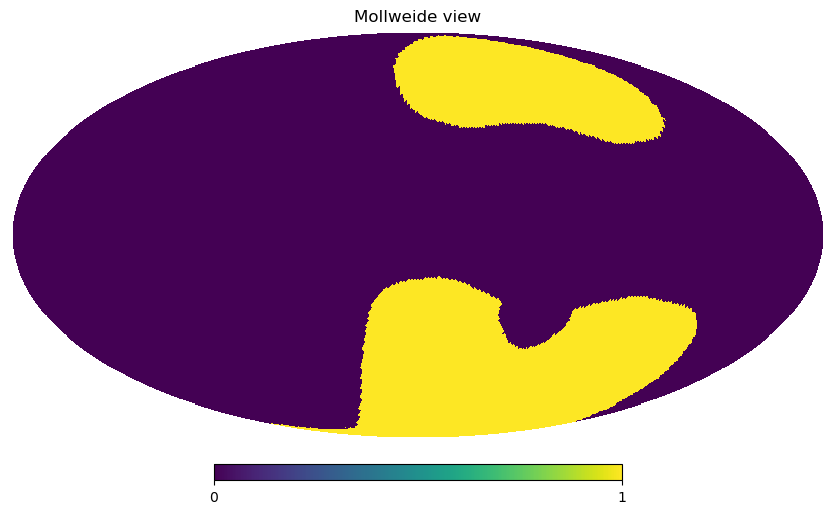

In [15]:
hp.mollview(mask_SO)

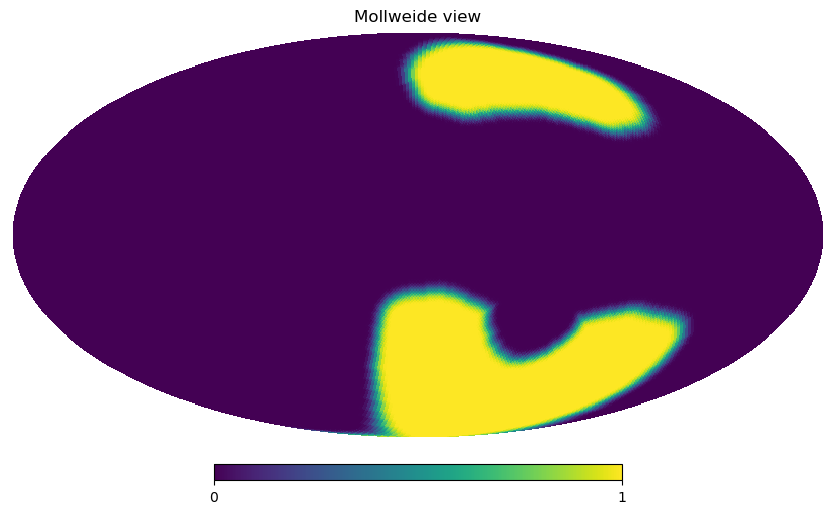

In [16]:
mask_apodized = nmt.mask_apodization(mask_SO, 10, apotype='C1')
hp.mollview(mask_apodized)

In [17]:
nside = 64
camb_cls_longer = generate_power_spectra_CAMB(nside*2)



Calculating spectra from CAMB !


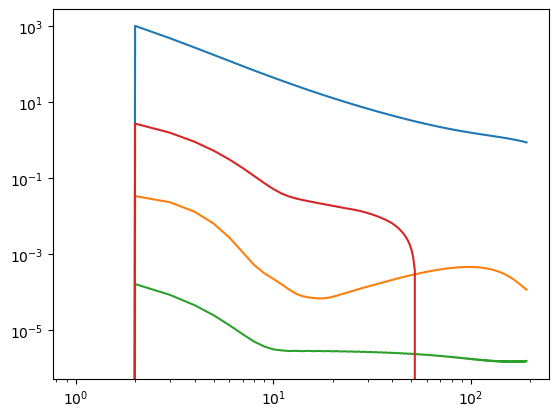

In [85]:
ell_camb = np.arange(camb_cls_longer.shape[0])

plt.plot(ell_camb, camb_cls_longer)
plt.loglog()
plt.show()

In [18]:
camb_cls_longer = camb_cls_longer[:3*nside]

In [77]:
mask_apodized = np.ones(12*nside**2)

In [89]:
delta_ell = 1
# lmax = 2*nside

larr = np.arange(3*nside)
clarr = ((larr+1.)/80.)**(-1.1)+1.
cl_tt = clarr
cl_ee = clarr
cl_bb = 0*clarr
cl_te = 0*clarr
cl_tb = 0*clarr
cl_eb = 0*clarr
camb_cls_longer_2 = np.array([cl_tt, cl_ee, cl_bb, cl_te, cl_tb, cl_eb])
covariance_matrix_dict = generate_full_covariance_matrix(nside, mask_apodized, camb_cls_longer.T, delta_ell, lmax=3*nside-1, new=True)
# covariance_matrix_dict = generate_full_covariance_matrix(nside, mask_apodized, camb_cls_longer_2, delta_ell, lmax=3*nside-1, new=True)

In [90]:
linthresh=10**(-5)

/tmp/ipykernel_85221/1211280470.py:4: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.colorbar()


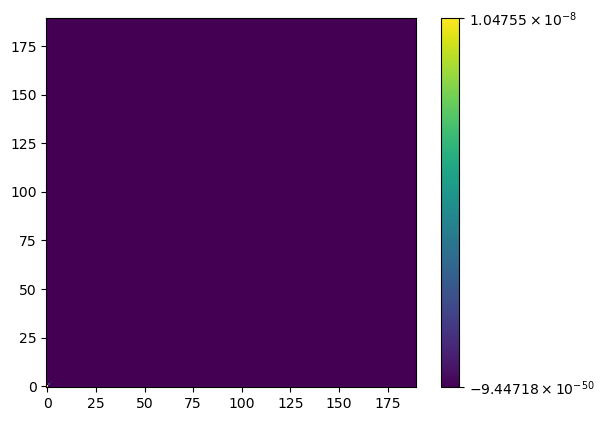

In [91]:
covariance_matrix_to_plot = covariance_matrix_dict['BB_BB'] #- covar_TT_TT
plt.figure()
plt.imshow(covariance_matrix_to_plot, origin='lower', interpolation='nearest', norm=SymLogNorm(linthresh=linthresh,vmin=-np.abs(covariance_matrix_to_plot[covariance_matrix_to_plot!=0]).min()))
plt.colorbar()

In [27]:
(camb_cls_longer.T[0][None,:]*camb_cls_longer.T[0][:,None]).shape

(192, 192)

In [44]:
nsamp = 100
w00 = nmt.NmtWorkspace()
bin_scheme = nmt.NmtBin.from_nside_linear(nside, 1)
w00.compute_coupling_matrix(spin_0_field, spin_0_field, bin_scheme)
covar_test = np.zeros([3*nside-2, 3*nside-2])
mean_test = np.zeros(3*nside-2)

for i in range(nsamp):
    maps_TQU = hp.synfast(camb_cls_longer.T,nside, new=True)
    spin_0_field = nmt.NmtField(mask_apodized, [maps_TQU[0]])
    cl_coupled = nmt.compute_coupled_cell(spin_0_field, spin_0_field)
    cl_decoupled = w00.decouple_cell(cl_coupled)
    covar_test += cl_decoupled[0][None,:]*cl_decoupled[0][:,None]
    mean_test += cl_decoupled[0]
    if (i%10 == 0):
        print(i)

0
10
20
30
40
50
60
70
80
90


In [45]:
covar_test_final = covar_test/nsamp
mean_test_final = mean_test/nsamp
covar_test_final -= mean_test_final[None, :] * mean_test_final[:, None]

In [35]:
# covar_test = camb_cls_longer.T[0][None,:]*camb_cls_longer.T[0][:,None]
# covar_test = cl_decoupled[0][None,:]*cl_decoupled[0][:,None]
# print(covar_test.shape)

(190, 190)


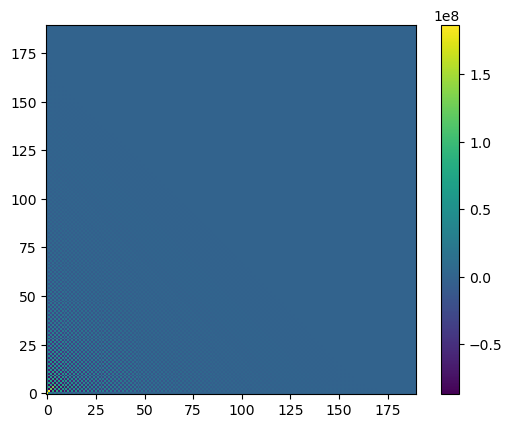

In [46]:
plt.figure()
plt.imshow(covar_test, origin='lower', interpolation='nearest')
plt.colorbar()

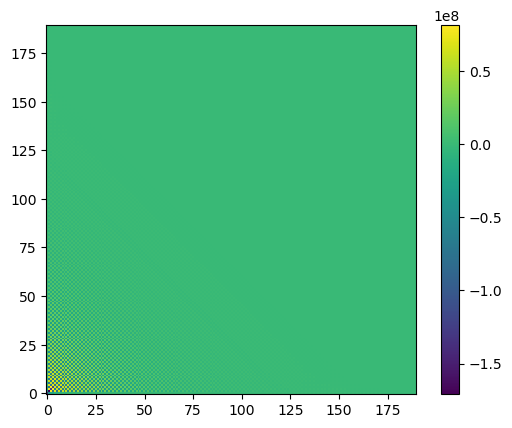

In [47]:
plt.figure()
plt.imshow(covariance_matrix_dict['TT_TT']-covar_test, origin='lower', interpolation='nearest')
plt.colorbar()

In [67]:
inv_covar_test = np.linalg.inv(covar_test)
print("End 1")
inv_covar_algo = np.linalg.inv(covariance_matrix_dict['TT_TT'])

End 1


In [71]:
c_ell_white_test = np.dot(inv_covar_test, cl_decoupled[0])
c_ell_white_algo = np.dot(inv_covar_algo, cl_decoupled[0])

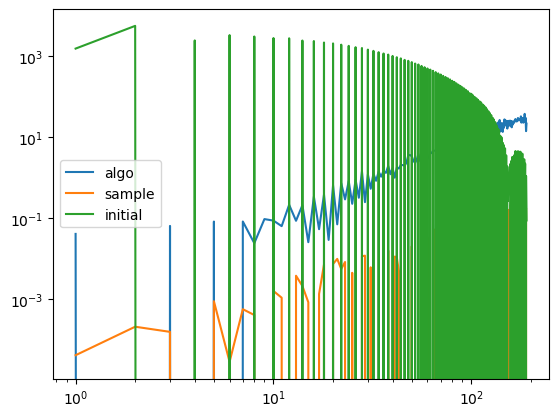

In [82]:
ell_white_test = np.arange(c_ell_white_test.shape[0])+1
ell_white_algo = np.arange(c_ell_white_algo.shape[0])+1


plt.plot(ell_white_algo, c_ell_white_algo, label='algo')
plt.plot(ell_white_test, c_ell_white_test, label='sample')
plt.plot(ell_white_test, cl_decoupled[0], label='initial')
plt.loglog()
plt.legend()
plt.show()

In [52]:
mask = np.ones(12*nside**2)

lon, lat = hp.pixelfunc.pix2ang(nside, np.arange(12*nside**2), lonlat=True)
mask[lat<0] = 0

mask_apodized = nmt.mask_apodization(mask, 10, apotype='C2')

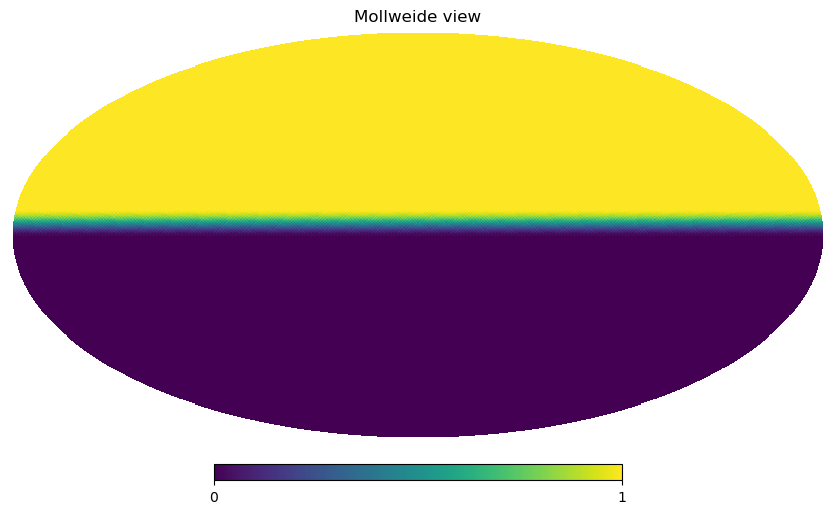

In [54]:
hp.mollview(mask_apodized)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 13.4 µs
Field


Workspace
Covariance
Sample covariance
0
10
20
30
40
50
60
70
80
90


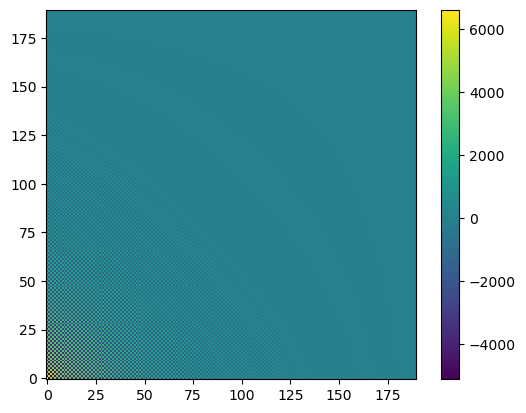

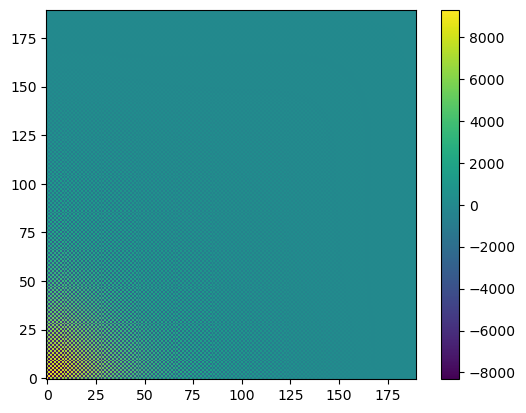

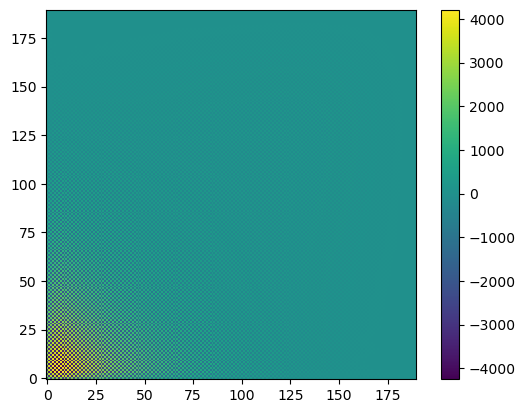

In [57]:
%time
delta_ell_2 = 1

larr = np.arange(3*nside)
clarr = ((larr+1.)/80.)**(-1.1)+1.
cl_tt = clarr
cl_ee = clarr
cl_bb = 0*clarr
cl_te = 0*clarr
cl_tb = 0*clarr
cl_eb = 0*clarr


# This routine generates a spin-0 and a spin-2 Gaussian random field based
# on these power spectra
def get_sample_field():
    mp_t, mp_q, mp_u = hp.synfast([cl_tt, cl_ee, cl_bb, cl_te],
                                  nside, verbose=False)
    return nmt.NmtField(mask_apodized, [mp_t]), nmt.NmtField(mask_apodized, [mp_q, mp_u])


# We also copy this function from sample_workspaces.py. It computes
# power spectra given a pair of fields and a workspace.
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)

    return cl_decoupled


# Let's generate one particular sample and its power spectrum.
print("Field")
f0, f2 = get_sample_field()
# We will use 20 multipoles per bandpower.
b = nmt.NmtBin.from_nside_linear(nside, delta_ell_2)
print("Workspace")
w00 = nmt.NmtWorkspace()
w00.compute_coupling_matrix(f0, f0, b)
w02 = nmt.NmtWorkspace()
w02.compute_coupling_matrix(f0, f2, b)
w22 = nmt.NmtWorkspace()
w22.compute_coupling_matrix(f2, f2, b)
cl_00 = compute_master(f0, f0, w00)
cl_02 = compute_master(f0, f2, w02)
cl_22 = compute_master(f2, f2, w22)
n_ell = len(cl_00[0])

# Let's now compute the Gaussian estimate of the covariance!
print("Covariance")
# First we generate a NmtCovarianceWorkspace object to precompute
# and store the necessary coupling coefficients
cw = nmt.NmtCovarianceWorkspace()
# This is the time-consuming operation
# Note that you only need to do this once,
# regardless of spin
cw.compute_coupling_coefficients(f0, f0, f0, f0)

# The next few lines show how to extract the covariance matrices
# for different spin combinations.
covar_00_00 = nmt.gaussian_covariance(cw,
                                      0, 0, 0, 0,  # Spins of the 4 fields
                                      [cl_tt],  # TT
                                      [cl_tt],  # TT
                                      [cl_tt],  # TT
                                      [cl_tt],  # TT
                                      w00, wb=w00).reshape([n_ell, 1,
                                                            n_ell, 1])
covar_TT_TT = covar_00_00[:, 0, :, 0]
covar_02_02 = nmt.gaussian_covariance(cw, 0, 2, 0, 2,  # Spins of the 4 fields
                                      [cl_tt],  # TT
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # ET, BT
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w02, wb=w02).reshape([n_ell, 2,
                                                            n_ell, 2])
covar_TE_TE = covar_02_02[:, 0, :, 0]
covar_TE_TB = covar_02_02[:, 0, :, 1]
covar_TB_TE = covar_02_02[:, 1, :, 0]
covar_TB_TB = covar_02_02[:, 1, :, 1]


covar_00_22 = nmt.gaussian_covariance(cw, 0, 0, 2, 2,  # Spins of the 4 fields
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      w00, wb=w22).reshape([n_ell, 1,
                                                            n_ell, 4])
covar_TT_EE = covar_00_22[:, 0, :, 0]
covar_TT_EB = covar_00_22[:, 0, :, 1]
covar_TT_BE = covar_00_22[:, 0, :, 2]
covar_TT_BB = covar_00_22[:, 0, :, 3]

covar_02_22 = nmt.gaussian_covariance(cw, 0, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w02, wb=w22).reshape([n_ell, 2,
                                                            n_ell, 4])
covar_TE_EE = covar_02_22[:, 0, :, 0]
covar_TE_EB = covar_02_22[:, 0, :, 1]
covar_TE_BE = covar_02_22[:, 0, :, 2]
covar_TE_BB = covar_02_22[:, 0, :, 3]
covar_TB_EE = covar_02_22[:, 1, :, 0]
covar_TB_EB = covar_02_22[:, 1, :, 1]
covar_TB_BE = covar_02_22[:, 1, :, 2]
covar_TB_BB = covar_02_22[:, 1, :, 3]


covar_22_22 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w22, wb=w22).reshape([n_ell, 4,
                                                            n_ell, 4])
covar_EE_EE = covar_22_22[:, 0, :, 0]
covar_EE_EB = covar_22_22[:, 0, :, 1]
covar_EE_BE = covar_22_22[:, 0, :, 2]
covar_EE_BB = covar_22_22[:, 0, :, 3]
covar_EB_EE = covar_22_22[:, 1, :, 0]
covar_EB_EB = covar_22_22[:, 1, :, 1]
covar_EB_BE = covar_22_22[:, 1, :, 2]
covar_EB_BB = covar_22_22[:, 1, :, 3]
covar_BE_EE = covar_22_22[:, 2, :, 0]
covar_BE_EB = covar_22_22[:, 2, :, 1]
covar_BE_BE = covar_22_22[:, 2, :, 2]
covar_BE_BB = covar_22_22[:, 2, :, 3]
covar_BB_EE = covar_22_22[:, 3, :, 0]
covar_BB_EB = covar_22_22[:, 3, :, 1]
covar_BB_BE = covar_22_22[:, 3, :, 2]
covar_BB_BB = covar_22_22[:, 3, :, 3]

# Let's now compute the sample covariance
# (we'll only do this for spin-0 for simplicity
print("Sample covariance")
nsamp = 100
covar_sample = np.zeros([n_ell, n_ell])
mean_sample = np.zeros(n_ell)
for i in np.arange(nsamp):
    # print(i)
    f, _ = get_sample_field()
    cl = compute_master(f, f, w00)[0]
    covar_sample += cl[None, :]*cl[:, None]
    mean_sample += cl
    if (i%10 == 0):
        print(i)
mean_sample /= nsamp
covar_sample = covar_sample / nsamp
covar_sample -= mean_sample[None, :] * mean_sample[:, None]

# Let's plot them:
plt.figure()
plt.imshow(covar_TT_TT, origin='lower', interpolation='nearest')
plt.colorbar()
plt.figure()
plt.imshow(covar_sample, origin='lower', interpolation='nearest')
plt.colorbar()
plt.figure()
plt.imshow(covar_TT_TT-covar_sample, origin='lower', interpolation='nearest')
plt.colorbar()
plt.show()

In [31]:
b.get_effective_ells()

array([  6.5,  16.5,  26.5,  36.5,  46.5,  56.5,  66.5,  76.5,  86.5,
        96.5, 106.5, 116.5, 126.5, 136.5, 146.5, 156.5, 166.5, 176.5,
       186.5])

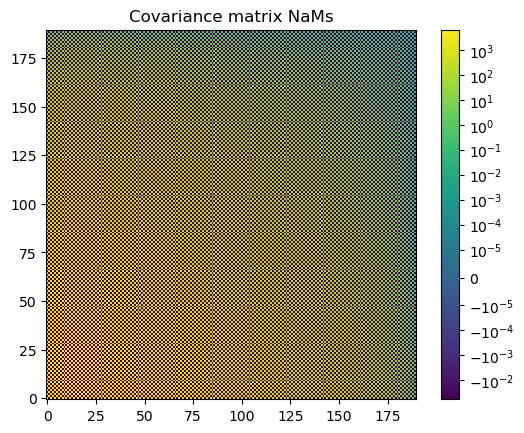

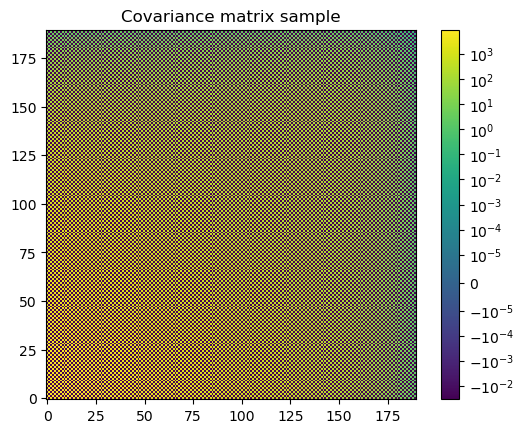

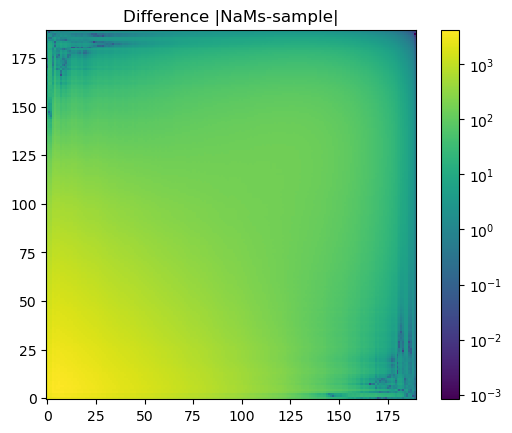

In [68]:

# Let's plot them:
plt.figure()
covariance_matrix_to_plot = covar_TT_TT
plt.imshow(covar_TT_TT, origin='lower', interpolation='nearest', norm=SymLogNorm(linthresh=linthresh,vmin=-np.abs(covariance_matrix_to_plot[covariance_matrix_to_plot!=0]).min()))
plt.colorbar()
plt.title("Covariance matrix NaMs")
plt.figure()
covariance_matrix_to_plot = covar_sample
plt.imshow(covar_sample, origin='lower', interpolation='nearest', norm=SymLogNorm(linthresh=linthresh,vmin=-np.abs(covariance_matrix_to_plot[covariance_matrix_to_plot!=0]).min()))
plt.colorbar()
plt.title("Covariance matrix sample")
plt.figure()
covariance_matrix_to_plot = np.abs(covar_TT_TT-covar_sample)
plt.imshow(covariance_matrix_to_plot, origin='lower', interpolation='nearest', norm=SymLogNorm(linthresh=linthresh,vmin=np.abs(covariance_matrix_to_plot[covariance_matrix_to_plot!=0]).min()))
plt.colorbar()
plt.title("Difference |NaMs-sample|")
plt.show()

In [40]:
new_ell_range.shape

(19,)

In [46]:
covar_TT_TT[new_ell_range,:][:,new_ell_range].shape

(16, 16)

In [49]:
true_ell_range

array([  6.5,  16.5,  26.5,  36.5,  46.5,  56.5,  66.5,  76.5,  86.5,
        96.5, 106.5, 116.5, 126.5, 136.5, 146.5, 156.5, 166.5, 176.5,
       186.5])

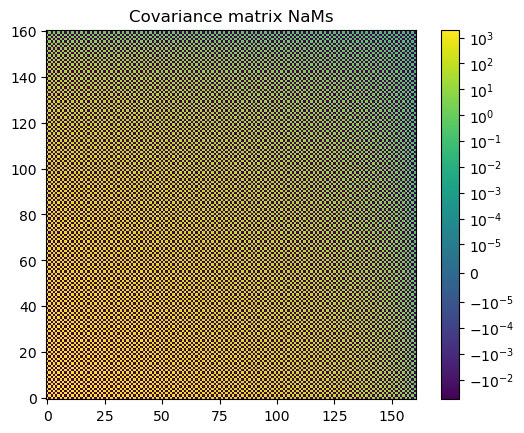

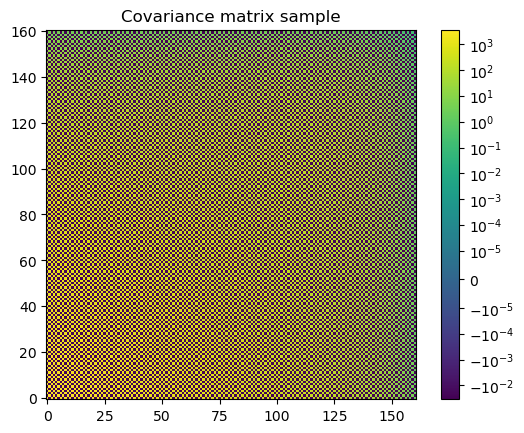

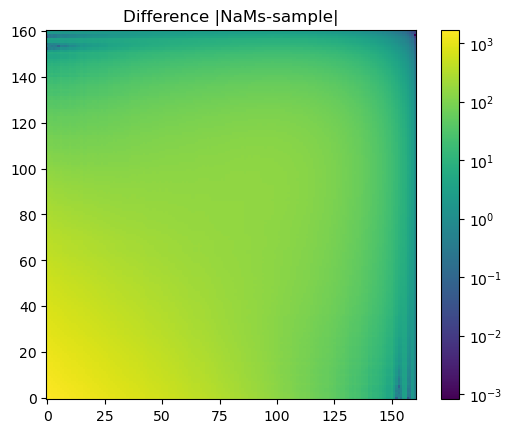

In [69]:
true_ell_range = b.get_effective_ells()
new_ell_range = true_ell_range>30
# Let's plot them:
plt.figure()
covariance_matrix_to_plot = covar_TT_TT[new_ell_range,:][:,new_ell_range]
plt.imshow(covariance_matrix_to_plot, origin='lower', interpolation='nearest', norm=SymLogNorm(linthresh=linthresh,vmin=-np.abs(covariance_matrix_to_plot[covariance_matrix_to_plot!=0]).min()))
plt.colorbar()
plt.title("Covariance matrix NaMs")
plt.figure()
covariance_matrix_to_plot = covar_sample[new_ell_range,:][:,new_ell_range]
plt.imshow(covariance_matrix_to_plot, origin='lower', interpolation='nearest', norm=SymLogNorm(linthresh=linthresh,vmin=-np.abs(covariance_matrix_to_plot[covariance_matrix_to_plot!=0]).min()))
plt.colorbar()
plt.title("Covariance matrix sample")
plt.figure()
covariance_matrix_to_plot = np.abs(covar_TT_TT-covar_sample)[new_ell_range,:][:,new_ell_range]
plt.imshow(covariance_matrix_to_plot, origin='lower', interpolation='nearest', norm=SymLogNorm(linthresh=linthresh,vmin=np.abs(covariance_matrix_to_plot[covariance_matrix_to_plot!=0]).min()))
plt.colorbar()
plt.title("Difference |NaMs-sample|")
plt.show()

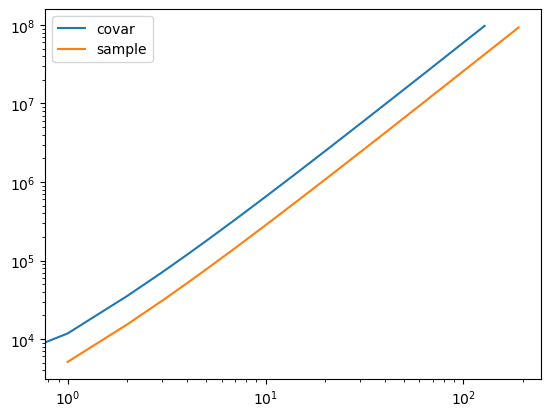

In [62]:
cl_tt_sample = np.diag(covar_sample)
cl_tt_covar = np.diag(covar_TT_TT)
ell_sample = np.arange(cl_tt_sample.shape[0])+1
factor_sample = ell_sample*(ell_sample+1)/(2*np.pi)
ell_covar = np.arange(camb_cls.shape[0])
factor_covar = ell_covar*(ell_covar+1)/(2*np.pi)


plt.plot(ell_covar, factor_covar*cl_tt_covar[0], label='covar')
plt.plot(ell_sample, factor_sample*cl_tt_sample[0], label='sample')
plt.loglog()
plt.legend()
plt.show()

In [92]:
cl_cov = np.dot(np.linalg.inv(covar_TT_TT), cl)
cl_samp = np.dot(np.linalg.inv(covar_sample), cl)



In [76]:
a = np.array([[1, 2, 3], [2, 3, 1], [3, 1, 2]])

print(np.linalg.inv(a))
print(np.dot(np.linalg.inv(a),a))

[[-0.27777778  0.05555556  0.38888889]
 [ 0.05555556  0.38888889 -0.27777778]
 [ 0.38888889 -0.27777778  0.05555556]]
[[ 1.00000000e+00  5.55111512e-17 -1.11022302e-16]
 [ 1.66533454e-16  1.00000000e+00  1.11022302e-16]
 [-6.24500451e-17 -7.63278329e-17  1.00000000e+00]]


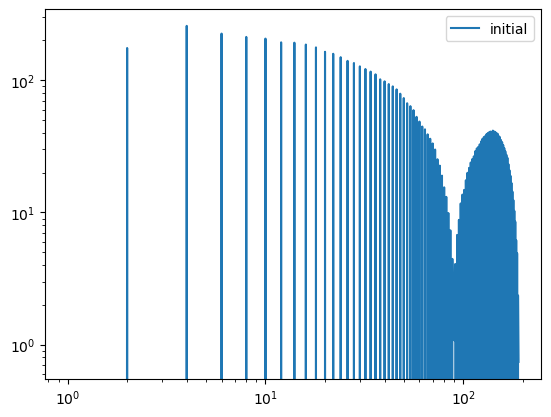

In [73]:
# ell_white_cov = np.arange(cl_cov.shape[0])+1
ell_white_samp = np.arange(cl.shape[0])+1


# plt.plot(ell_white_cov*delta_ell_2, cl_cov, label='cov')
# plt.plot(ell_white_samp*delta_ell_2, cl_samp, label='sample')
plt.plot(ell_white_samp*delta_ell_2, cl, label='initial')
plt.loglog()
plt.legend()
plt.show()

In [55]:
cl_tt_test = np.diag(covariance_matrix_dict['TT_TT'])

In [56]:
cl_tt_test.shape

(190,)

In [87]:
np.arange(cl.shape[0])*delta_ell_2

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180])

In [70]:
ell_test = np.arange(cl_tt_test.shape[0])+1
factor_test = ell_test*(ell_test+1)/(2*np.pi)
ell_camb = np.arange(camb_cls.shape[0])
factor_camb = ell_camb*(ell_camb+1)/(2*np.pi)
ell_sample = np.arange(cl.shape[0])*delta_ell_2
factor_sample = ell_sample*(ell_sample+1)/(2*np.pi)

plt.plot(ell_camb, factor_camb*camb_cls.T[0], label='CAMB')
plt.plot(ell_test, factor_test*cl_tt_test[0], label='covar TT')
plt.plot(ell_sample, factor_sample*cl[0], label='sample')
plt.loglog()
plt.legend()
plt.show()

NameError: name 'cl_tt_test' is not defined

In [99]:
covar_cl = cl[None,:]*cl[:,None]
mean_cl = cl

covar_cl_inv = np.linalg.inv(covar_cl)
covar_cl_cho = np.linalg.cholesky(covar_cl_inv)

LinAlgError: Matrix is not positive definite

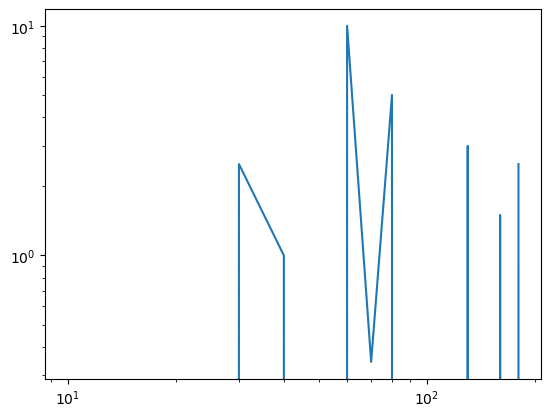

In [102]:
tes_cl = np.dot(covar_cl_inv, cl)

plt.plot(np.arange(tes_cl.shape[0])*delta_ell_2, tes_cl)
plt.loglog()
plt.show()

In [103]:
covar_cl = cl_decoupled[0][None,:]*cl_decoupled[0][:,None]

covar_cl_inv = np.linalg.inv(covar_cl)
covar_cl_cho = np.linalg.cholesky(covar_cl_inv)

LinAlgError: Matrix is not positive definite

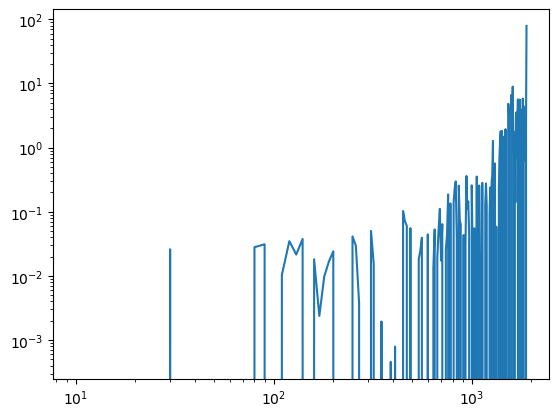

In [105]:
tes_cl = np.dot(covar_cl_inv, cl_decoupled[0])

plt.plot(np.arange(tes_cl.shape[0])*delta_ell_2, tes_cl)
plt.loglog()
plt.show()